In [1]:
import os
import sys
import torch

import monai
from PIL import Image
from tqdm import tqdm
from monai.utils import first
from generative.inferers import LatentDiffusionInferer
from generative.networks.schedulers import DDIMScheduler

from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from pretrained import load_autoencoder, load_unet
import utils

BUNDLE = 'brats_mri_class_cond'
sys.path.append(BUNDLE)
from scripts.inferer import LatentDiffusionInfererWithClassConditioning
from scripts.utils import compute_scale_factor
from scripts.ct_rsna import CTSubset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [2]:
batch_size = 4
train_loader = DataLoader(CTSubset('../data/ct-rsna/train/', 'train_set_dropped_nans.csv',
                                        size=256, flip_prob=0.5, subset_len=128),
                                        batch_size=batch_size, shuffle=True, drop_last=True)

val_loader = DataLoader(CTSubset('../data/ct-rsna/validation/', 'validation_set_dropped_nans.csv',
                                    size=256, flip_prob=0., subset_len=32),
                                    batch_size=batch_size, shuffle=True, drop_last=True)

Data source: train_set_dropped_nans.csv
    Class none: 50.0%
    Class epidural: 11.7%
    Class intraparenchymal: 12.5%
    Class intraventricular: 7.8%
    Class subarachnoid: 9.4%
    Class subdural: 8.6%
Data source: validation_set_dropped_nans.csv
    Class none: 53.1%
    Class epidural: 6.2%
    Class intraparenchymal: 6.2%
    Class intraventricular: 15.6%
    Class subarachnoid: 9.4%
    Class subdural: 9.4%


In [3]:
# load autoencoder
autoencoder_pre = load_autoencoder(bundle_target=BUNDLE)
autoencoder = load_autoencoder(bundle_target=BUNDLE)


In [4]:
def compute_kl_loss(z_mu, z_sigma):
    kl_loss = 0.5 * torch.sum(
        z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=list(range(1, len(z_sigma.shape)))
    )
    return torch.sum(kl_loss) / kl_loss.shape[0]

def naive_train_loop(autoencoder, dataloader, L, optimizer):
    autoencoder.train()
    kl_weight = 1e-6
    total_loss = 0
    with tqdm(dataloader, desc='  Training loop', total=len(dataloader)) as pbar:
        for batch in pbar:
            ims = batch['image'].to(device)
            ims_recon, z_mu, z_sigma = autoencoder(ims)
            l1_loss = L(ims.float(), ims_recon.float())
            kl_loss = compute_kl_loss(z_mu, z_sigma)
            loss = l1_loss + kl_weight * kl_loss
            pbar.set_postfix({"loss": loss.item()})

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        pbar.set_postfix({"loss": avg_loss})
    return avg_loss

@torch.no_grad
def naive_val_loop(autoencoder, dataloader, L):
    autoencoder.eval()
    total_loss = 0
    with tqdm(dataloader, desc='  Validation loop', total=len(dataloader)) as pbar:
        for batch in pbar:
            ims = batch['image'].to(device)
            ims_recon, _, _ = autoencoder(ims)
            loss = L(ims.float(), ims_recon.float())
            pbar.set_postfix({"loss": loss.item()})

            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        pbar.set_postfix({"loss": avg_loss})
    return avg_loss

In [17]:
last_epoch = 0
torch.cuda.empty_cache()


In [6]:
torch.cuda.empty_cache()

# import generative.losses.PerceptualLoss

try:
    last_epoch = e
except:
    last_epoch = 0

num_epochs = 20
val_every_n_epochs = 2
lr = 1e-5

L = torch.nn.L1Loss()
optimizer = Adam(list(autoencoder.parameters()), lr=lr)
lr_scheduler = CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-6)

losses = {
    'train': [],
    'validation': [],
}
for e in range(last_epoch + 1, last_epoch + num_epochs + 1):
    print(f'Epoch #[{e}/{last_epoch + num_epochs}]:')
    train_loss = naive_train_loop(autoencoder, train_loader, L, optimizer)
    losses['train'].append((e, train_loss))
    lr_scheduler.step()
    if e % val_every_n_epochs == 0:
        val_loss = naive_val_loop(autoencoder, val_loader, L)
        losses['validation'].append((e, val_loss))

Epoch #[1/20]:


  Training loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:29<00:00,  1.07it/s, loss=0.0414]


Epoch #[2/20]:


  Validation loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.96it/s, loss=0.0337]


Epoch #[3/20]:


  Training loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:22<00:00,  1.43it/s, loss=0.0225]


Epoch #[4/20]:


  Validation loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.54it/s, loss=0.0268]


Epoch #[5/20]:


  Training loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:23<00:00,  1.39it/s, loss=0.0492]


Epoch #[6/20]:


  Validation loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.05it/s, loss=0.0283]


Epoch #[7/20]:


  Training loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:24<00:00,  1.31it/s, loss=0.0255]


Epoch #[8/20]:


  Validation loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.41it/s, loss=0.022]


Epoch #[9/20]:


  Training loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:24<00:00,  1.31it/s, loss=0.0308]


Epoch #[10/20]:


  Validation loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.02it/s, loss=0.0134]


Epoch #[11/20]:


  Training loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:24<00:00,  1.32it/s, loss=0.028]


Epoch #[12/20]:


  Validation loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.43it/s, loss=0.0196]


Epoch #[13/20]:


  Training loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:24<00:00,  1.30it/s, loss=0.0251]


Epoch #[14/20]:


  Validation loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.98it/s, loss=0.0182]


Epoch #[15/20]:


  Training loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:24<00:00,  1.31it/s, loss=0.018]


Epoch #[16/20]:


  Validation loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.42it/s, loss=0.0265]


Epoch #[17/20]:


  Training loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:24<00:00,  1.31it/s, loss=0.0261]


Epoch #[18/20]:


  Validation loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.01it/s, loss=0.0185]


Epoch #[19/20]:


  Training loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:24<00:00,  1.31it/s, loss=0.0289]


Epoch #[20/20]:


  Validation loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.45it/s, loss=0.0129]


In [7]:
losses

{'train': [(1, 0.05222221801523119),
  (2, 0.04014569177525118),
  (3, 0.03652750205947086),
  (4, 0.034647503576707095),
  (5, 0.0332685096655041),
  (6, 0.03238555433927104),
  (7, 0.03146375244250521),
  (8, 0.030867267691064626),
  (9, 0.030434377258643508),
  (10, 0.030049279157537967),
  (11, 0.029706463683396578),
  (12, 0.02951037953607738),
  (13, 0.029323822061996907),
  (14, 0.02914712467463687),
  (15, 0.028967847290914506),
  (16, 0.028858616075012833),
  (17, 0.02881867188261822),
  (18, 0.028766504547093064),
  (19, 0.028734430496115237),
  (20, 0.028580879559740424)],
 'validation': [(2, 0.025812334613874555),
  (4, 0.02213121927343309),
  (6, 0.020580698386766016),
  (8, 0.019686046289280057),
  (10, 0.019430624088272452),
  (12, 0.0190912518883124),
  (14, 0.01889659953303635),
  (16, 0.018750739051029086),
  (18, 0.01890662219375372),
  (20, 0.01844938611611724)]}

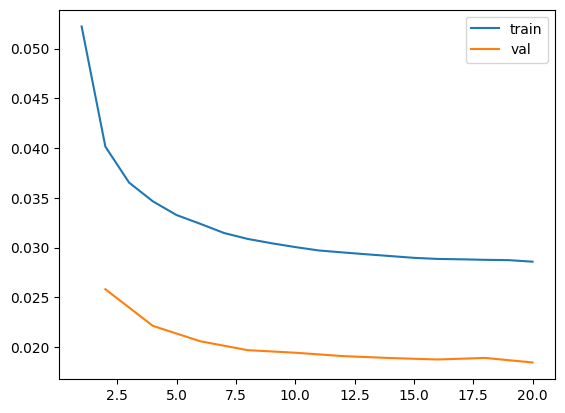

In [13]:
# plot losses
from matplotlib import pyplot as plt

train_epochs = [x[0] for x in losses['train']]
train_loss = [x[1] for x in losses['train']]

val_epochs = [x[0] for x in losses['validation']]
val_loss = [x[1] for x in losses['validation']]

plt.plot(train_epochs, train_loss, label='train')
plt.plot(val_epochs, val_loss, label='val')
plt.legend()
plt.show()

In [22]:

# plot reconstructions

for batch in train_loader:
    im = batch['image'].to(device)
    break

# im = 2*im - 1
im_recon_pre, _, _ = autoencoder_pre(im)
im_recon, _, _ = autoencoder(im)
plot_src_and_recon(im, im_recon_pre)
plot_src_and_recon(im, im_recon)


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.58 GiB of which 11.56 MiB is free. Including non-PyTorch memory, this process has 14.56 GiB memory in use. Of the allocated memory 14.26 GiB is allocated by PyTorch, and 158.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [10]:
from matplotlib import pyplot as plt

def plot_src_and_recon(im, recon_im):
    im = im.detach().cpu().numpy()[0, 0, :, :].squeeze()
    recon_im = recon_im.detach().cpu().numpy()[0, 0, :, :].squeeze()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figsize as needed

    # Plot the first image on the first subplot
    axes[0].imshow(im, cmap = plt.cm.bone)
    axes[0].set_title('Input image')
    
    # Plot the second image on the second subplot
    axes[1].imshow(recon_im, cmap = plt.cm.bone)
    axes[1].set_title('Autoencoder reconstruction')
    
    # Adjust layout to prevent overlapping of subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()

    # Create a figure with two subplots arranged side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figsize as needed
    
    # Plot the intensity distribution of the first image
    axes[0].hist(im.ravel(), bins=256, range=(0, 1), color='blue', alpha=0.7)
    axes[0].set_title('Intensity Distribution - Input')
    axes[0].set_xlabel('Pixel Intensity')
    axes[0].set_ylabel('Frequency')
    
    # Plot the intensity distribution of the second image
    axes[1].hist(recon_im.ravel(), bins=256, range=(0, 1), color='red', alpha=0.7)
    axes[1].set_title('Intensity Distribution - reconstruction')
    axes[1].set_xlabel('Pixel Intensity')
    axes[1].set_ylabel('Frequency')
    
    # Adjust layout to prevent overlapping of subplots and titles
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def print_img_stats(img, img_name):
    print(f"{img_name} - stats")
    print(f"img max: {img.max()}")
    print(f"img min: {img.min()}")
    print(f"img mean: {img.mean()}")
    print(f"img std: {img.std()}")
    


reconstruct with Variation


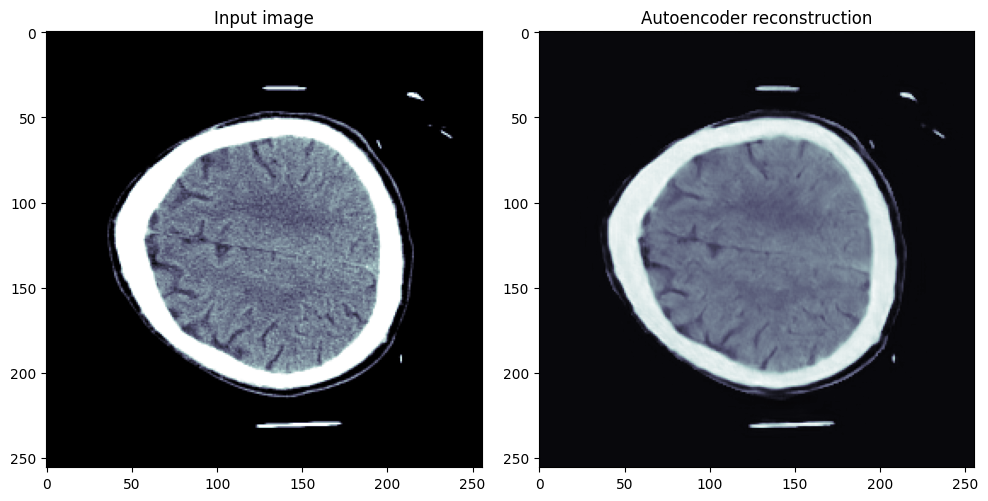

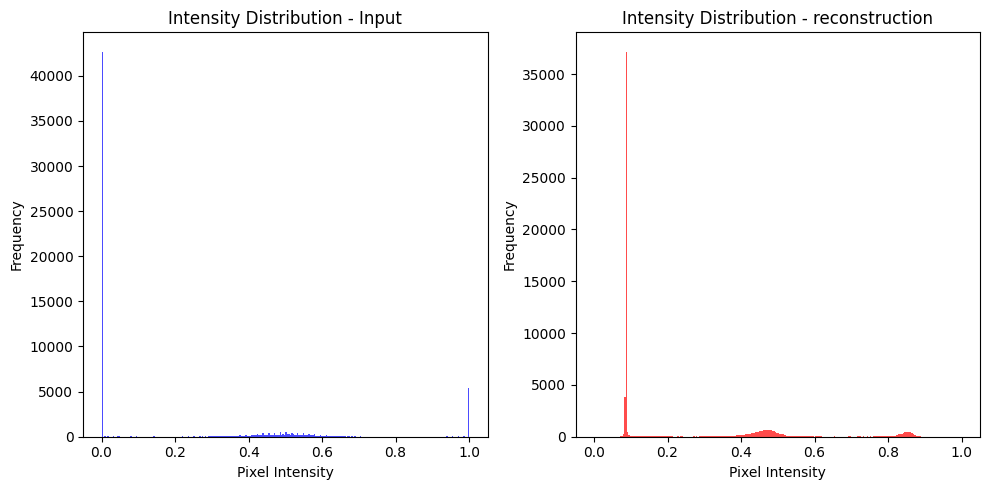

Source - stats
img max: 1.0
img min: 0.0
img mean: 0.2032240331172943
img std: 0.35016846656799316
VAE Recon - stats
img max: 1.0
img min: 0.0
img mean: 0.23895478248596191
img std: 0.26059821248054504


In [15]:
# evaluate autoencoder dependence on input dynamic range...

for batch in train_loader:
    im = batch['image'].to(device)
    break

# im = 2*im - 1
im_recon, _, _ = autoencoder(im)
z_mu = autoencoder.reconstruct(im)

im_recon = (im_recon-im_recon.min()) / (im_recon.max()-im_recon.min())
# im_recon = (im_recon**2)
# im_recon = torch.sqrt(im_recon + 0.2)
# im_recon = torch.clip(im_recon, 0, 1)

# print('reconstruct without Variation')
# plot_src_and_recon(im, z_mu)
# print_img_stats(im, 'Source')
# print_img_stats(z_mu, 'Recon')

print('')
print('reconstruct with Variation')
plot_src_and_recon(im, im_recon)
print_img_stats(im, 'Source')
print_img_stats(im_recon, 'VAE Recon')

In [91]:
import numpy as np
im_np = im[0,0,:,:].detach().cpu().numpy().squeeze()
recon_im_np = im_recon[0,0,:,:].detach().cpu().numpy().squeeze()
print(im_np.shape)
x,y = np.where(im_np == 1.)
x_recon,y_recon = np.where(recon_im_np == 1.)
x[-4:-1]
y[-4:-1]

(256, 256)


array([ 99, 100,  98])

In [114]:
@torch.no_grad()
def log_ims_local(unet, autoencoder, inferer, noise_shape,
            im_tag, data_sample, n_classes=6, max_ims=4):

    unet.eval()
    autoencoder.eval()

    max_ims = min(max_ims, len(data_sample['image']))

    input_ims = data_sample['image'].to(device)[:max_ims]
    encode_decode, _, _ = autoencoder(input_ims)

    input_col = torch.vstack([im.squeeze() for im in input_ims])
    output_col = torch.vstack([im.squeeze() for im in encode_decode])
    log_im = utils.rescale_outputs(torch.hstack((input_col, output_col)))

    log_im = Image.fromarray(log_im)
    log_im.save(im_tag + '_encoder.png')

    scheduler = DDIMScheduler(num_train_timesteps=1000,
                              beta_start=0.0015, beta_end=0.0195,
                              schedule='scaled_linear_beta', clip_sample=False)
    scheduler.set_timesteps(num_inference_steps=200)
    rows = []
    for n in range(4):
        noise = torch.randn(noise_shape, device=device)
        # TODO - better pass this as argument and not use as global
        if use_context:
            if not use_conditioning:
                label = None
            else:
                label = torch.full((1, 1, 1), n, dtype=torch.float32, device=device)
            _, images = inferer.sample(input_noise=noise,
                                    save_intermediates=True,
                                    intermediate_steps=200,
                                    autoencoder_model=autoencoder,
                                    diffusion_model=unet,
                                    scheduler=scheduler,
                                    conditioning=label)
        else:
            label = torch.full((1,), n, dtype=torch.long, device=device)
            _, images = inferer.sample(input_noise=noise,
                                    save_intermediates=True,
                                    intermediate_steps=200,
                                    autoencoder_model=autoencoder,
                                    diffusion_model=unet,
                                    scheduler=scheduler,
                                    class_labels=label)   

        row = torch.cat(images, dim=-1).squeeze() # H x (4xW)
        rows.append(row)
    log_im = utils.rescale_outputs(torch.vstack(rows))
    log_im = Image.fromarray(log_im)
    log_im.save(im_tag + '_sample.png')


In [115]:
from main import log_ims
from generative.inferers import LatentDiffusionInferer
from scripts.utils import compute_scale_factor


config = utils.model_config(BUNDLE, 'train_diffusion.json')
scale_factor = compute_scale_factor(autoencoder, train_loader, device)

scheduler = config.get_parsed_content('noise_scheduler')
latent_shape = config.get_parsed_content('latent_shape')
sample_noise_shape = [1] + latent_shape

inferer = LatentDiffusionInferer(scheduler=scheduler, scale_factor=scale_factor)
use_context=True
use_conditioning=False
unet = load_unet(bundle_target=BUNDLE,
                 use_conditioning=False,
                 context_conditioning=True,
                 )

im_tag = 'sampling_chk200'
log_ims_local(unet, autoencoder, inferer, sample_noise_shape,
        im_tag, first(val_loader), len(train_loader.dataset.class_names))

Computing scale factor: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 15.02it/s]


Scale factor: 0.59366


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 32.03it/s]


In [1]:
import os
import sys
import torch
import monai
from PIL import Image
from tqdm import tqdm
from monai.utils import first
from generative.inferers import LatentDiffusionInferer
from generative.networks.schedulers import DDIMScheduler
import numpy as np

from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# from pretrained import load_autoencoder, load_unet
# import utils

BUNDLE = 'brats_mri_class_cond'
sys.path.append(BUNDLE)
# from scripts.inferer import LatentDiffusionInfererWithClassConditioning
# from scripts.utils import compute_scale_factor
from scripts.ct_rsna import CTSubset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

monai.utils.set_determinism(seed=42)
train_loader = DataLoader(CTSubset('../data/ct-rsna/train/', 'train_set_dropped_nans.csv',
                                        size=256, flip_prob=0., subset_len=16),
                                        batch_size=16, shuffle=True, drop_last=True)




Data source: train_set_dropped_nans.csv
    Class none: 50.0%
    Class epidural: 0.0%
    Class intraparenchymal: 12.5%
    Class intraventricular: 6.2%
    Class subarachnoid: 12.5%
    Class subdural: 18.8%


label: 5


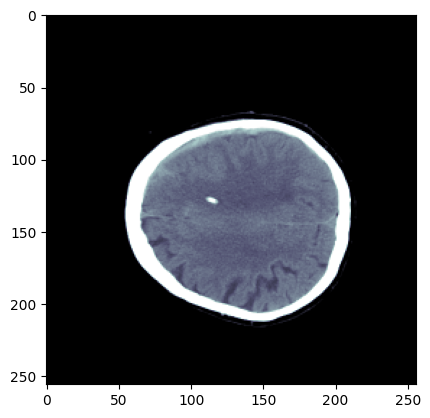

label: 5


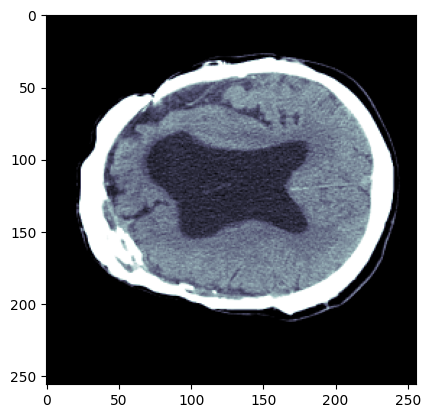

label: 5


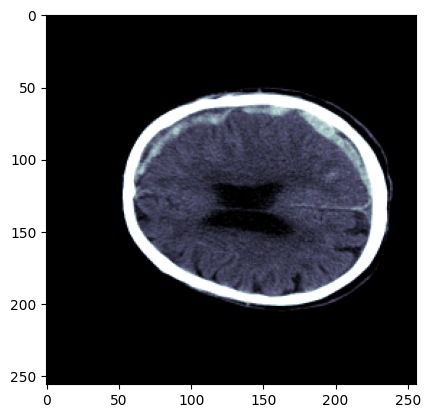

In [13]:
from matplotlib import pyplot as plt
# plot all in dataset:

batch = next(iter(train_loader))
ims = batch['image']
labels = batch['class_label']

n_ims = ims.shape[0]

for i in range(n_ims):
    if labels[i] == 5:
        im_np = ims[i, 0, :, :].detach().cpu().numpy().squeeze() 
        print(f"label: {labels[i]}")
        plt.imshow(im_np, cmap=plt.cm.bone)
        plt.show()
    